# Classifying GOES Image with Logistic Regression

Now that we've downloaded the data, let's try to run a simple logistic regression model to identify if an image contains a hurricane. We'll need to do a couple of things:

1. Read in the training data
2. Split the data into training and testing data
3. Build the simple logistic regression neural network
4. Train the model on the training data
5. Test the trained model on the testing data

I don't expect this to perform very well, but I'd like use this as a starting point to build more complex models to do so. Let's see how it works!

## Import Modules

First, let's grab all of the modules we need.

In [1]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import os
import random

## Build the Training Data Arrays

Before we build the model, we have to pull in the training data, which are stored as images.

### Build Custom Functions

We'll need to create a function to go in and fetch all of the training samples. They are currently stored in `../training/images/` under the corresponding `positive` or `negative` directories. So first, we create a function to build a randomized list of training and test data samples corresponding to the proper training/testing data split ratio and the specified number of images to fetch. Rather than read the images in at this point, we'll return a list of image paths and then create a separate function to read in the images from the paths.

In [4]:
def build_dataset(numImages,trainingSplit,imageBaseDir="../training_data/images/",positiveSplit=0.5):
    
    # Get the number of negative and positive images
    numPositiveImages = int(numImages*positiveSplit)
    numNegativeImages = numImages-numPositiveImages

    # Get a list of file names
    positiveImageFileList = [fileName for fileName in os.listdir(imageBaseDir+"positive/") if fileName.endswith("png")][:numPositiveImages]
    positiveImageFileList = [imageBaseDir+"positive/"+fileName for fileName in positiveImageFileList]
    negativeImageFileList = [fileName for fileName in os.listdir(imageBaseDir+"negative/") if fileName.endswith("png")][:numNegativeImages]
    negativeImageFileList = [imageBaseDir+"negative/"+fileName for fileName in negativeImageFileList if fileName.endswith("png")]

    # Loop through and get all of the positive examples
    positiveList = []
    for positiveImageFile in positiveImageFileList:
        positiveList.append([positiveImageFile,1])

    # Loop through and get all of the negative examples
    negativeList = []
    for negativeImageFile in negativeImageFileList:
        negativeList.append([negativeImageFile,0])

    # Put the list together and shuffle the list
    fullList = positiveList+negativeList
    random.shuffle(fullList)

    # Get the number of training/test samples
    numTrainImages = int(numImages*trainingSplit)
    numTestImages = numImages-numTrainImages

    # Get the samples corresponding to the training/testing split
    trainSampleList = fullList[:numTrainImages]
    testSampleList = fullList[-numTestImages:]
    
    # Split off x and y for the training and testing sets
    xTrain = [trainSample[0] for trainSample in trainSampleList]
    yTrain = [trainSample[1] for trainSample in trainSampleList]
    xTest = [testSample[0] for testSample in testSampleList]
    yTest = [testSample[1] for testSample in testSampleList]
    
    return xTrain, yTrain, xTest, yTest

def load_data(imagePathList):
    
    # Loop through the path and load the images
    dataList = []
    for imagePath in imagePathList:
        
        # Read the image
        image = Image.open(imagePath)
        dataList.append(np.asarray(image)[:,:,0]/255.)
        
    return np.asarray(dataList)

def normalize_samples(x):
    
    # Get normalization parameters
    mu = x.mean()
    sigma = x.std()
    
    return mu,sigma,(x-mu)/sigma

### Load the Training Data

Let's now use our functions above to read in the training data. We'll go back and load in the testing data once we're done. First, load up the randomized image paths.

In [5]:
xTrainPath,yTrainList,xTestPath,yTestList = build_dataset(300,0.7)
print("Training data size:",len(xTrainPath))
print("Testing data size:",len(xTestPath))

Training data size: 210
Testing data size: 90


Now we load in the training data from the randomized image paths. The training data array will come in size $m_{train} \times n_p \times n_p$ where $m_{train}$ is the number of training samples and $n_p$ is the number of pixels in one dimension of the training sample image array. We want to flatten that to be of size $m_{train}$ different columns of $(n_p)^2 \times 1$ arrays. 

In [6]:
# Load the training and testing data
xTrain = load_data(xTrainPath)
xTest = load_data(xTestPath)

# Reshape the example data
xTrainFlatten = xTrain.reshape(xTrain.shape[0],-1).T
xTestFlatten = xTest.reshape(xTest.shape[0],-1).T

# Cast lists to arrays of the proper size
yTrain = np.asarray(yTrainList).reshape(1,len(yTrainList))
yTest = np.asarray(yTestList).reshape(1,len(yTestList))

# Normalize the training and testing sets
muTrain, sigmaTrain, xTrainFlatten = normalize_samples(xTrainFlatten)
muTest, sigmaTest, xTestFlatten = normalize_samples(xTestFlatten)

# Print off the array shapes and some additional information
print("Shape of xTrain: "+str(xTrain.shape))
print("Shape of xTrainFlatten: "+str(xTrainFlatten.shape))
print("Shape of yTrain: "+str(yTrain.shape))
print("Training Data: Min: "+str(xTrainFlatten.min())+" Max: "+str(xTrainFlatten.max())+" Mean: "+str(xTrainFlatten.mean()))
print("Shape of xTest: "+str(xTest.shape))
print("Shape of xTestFlatten: "+str(xTestFlatten.shape))
print("Shape of yTest: "+str(yTest.shape))
print("Testing Data: Min: "+str(xTestFlatten.min())+" Max: "+str(xTestFlatten.max())+" Mean: "+str(xTestFlatten.mean()))

Shape of xTrain: (210, 498, 498)
Shape of xTrainFlatten: (248004, 210)
Shape of yTrain: (1, 210)
Training Data: Min: -1.3300037978636539 Max: 1.9242740054083634 Mean: -2.7399133774352935e-15
Shape of xTest: (90, 498, 498)
Shape of xTestFlatten: (248004, 90)
Shape of yTest: (1, 90)
Testing Data: Min: -1.5138252848799647 Max: 1.5647489945459065 Mean: -8.961149139794447e-16


We can plot some of our training samples. Here, we plot the first five in our training set. We've set up the custom functions above to set $y=1$ if there is an IBTRaCS observation in the image and $y=0$ if there was no observation. Of course, this depends on any limitations we placed on the IBTRaCS data. For example, we only counted observations with "TS", or tropical storm, nature. Also, we only need the flattened array after we plot these examples, so let's save some memory and delete it here.

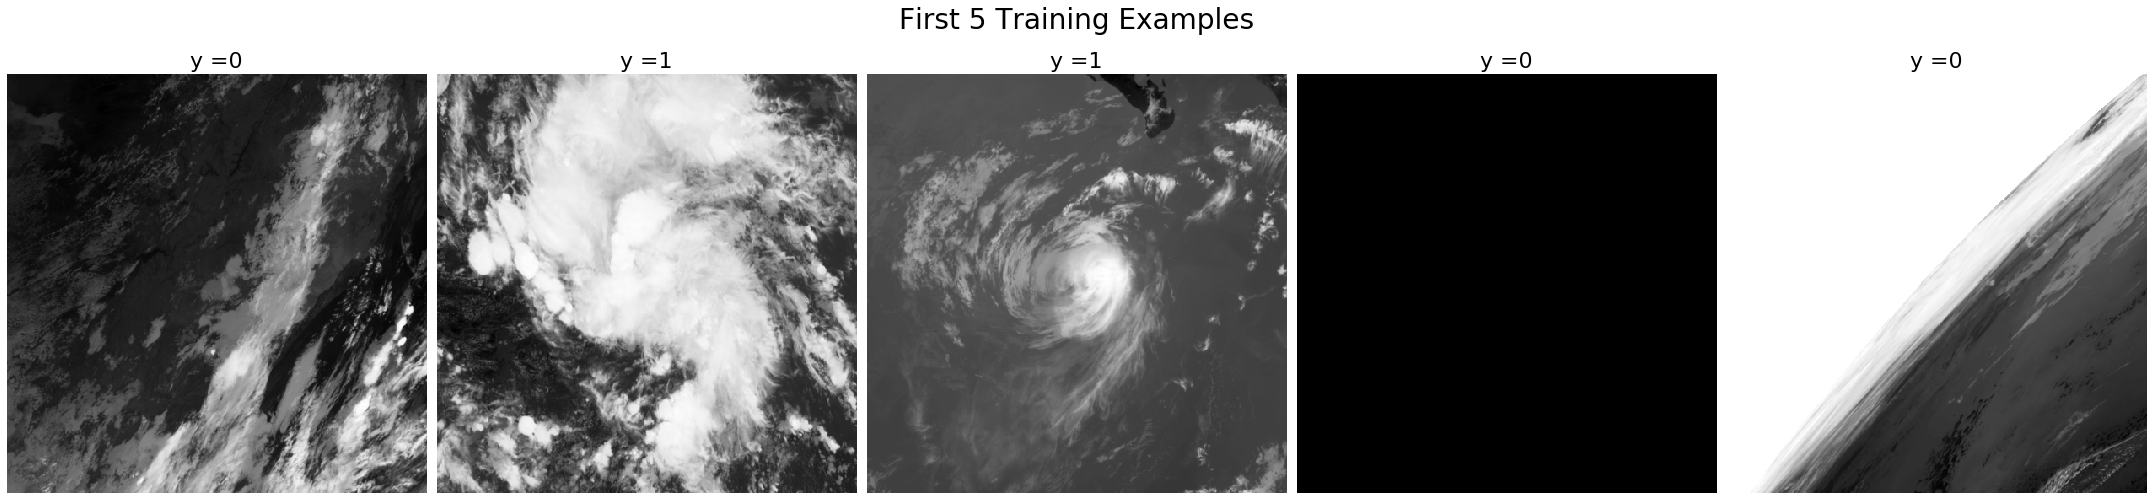

In [7]:
# PLot 5 examples
fig,ax = plt.subplots(1,5,figsize=(30,8))
for i in range(5):
    ax[i].imshow(xTrain[i],cmap='gray');
    ax[i].axis('off');
    ax[i].set_title("y ="+str(yTrain[0,i]),fontsize=22);
plt.tight_layout()
fig.suptitle("First 5 Training Examples",fontsize=28);

# Delete old arrays to save memory
del(xTrain)
del(xTest)

## Build the Logistic Regression Model

Now we'll define all of the functions we need to perform the logistic regression and run the functions step-by-step to step through the model.

### Sigmoid Function

We'll start with a function that takes as input an argument $s$ and returns the output $z = \sigma (s)$ where

$$
\sigma(s) = \frac{1}{1 + \exp(-s)}.
$$

In [8]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    s = 1./(1.+np.exp(-z))
    
    return s

Let's check to see if the sigmoid function works as expected. We'll just run the function on a small range of values as a sanity check.

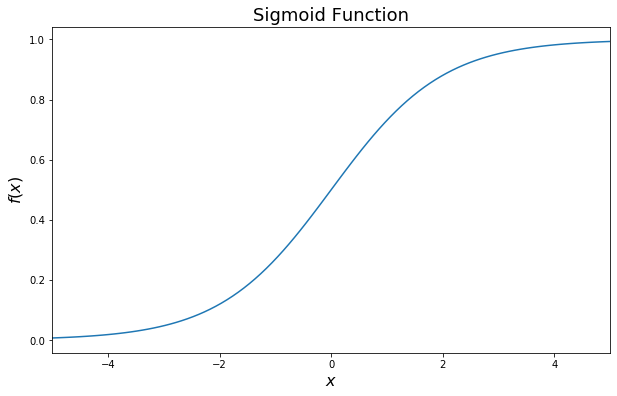

In [9]:
# Create small array and get the sigmoid function of it
x = np.linspace(-5,5,100)
f = sigmoid(x)

# Plot sigmoid function
fig,ax = plt.subplots(figsize=(10,6));
ax.plot(x,f);
ax.set_xlim(min(x),max(x));
ax.set_ylabel('$f(x)$',fontsize=16);
ax.set_xlabel('$x$',fontsize=16);
ax.set_title("Sigmoid Function",fontsize=18);

## Initalize Parameters

We'll have two parameters; the weights $w$ and the bias $b$. We can initialize these as simply zeros, and then update our parameters later with backpropagation.

In [10]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    # Set parameters to zeros
    w = np.zeros((dim,1))
    b = 0.0

    # Make assertions
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

## Forward and Backward Propagation

Since our logistic regression model is simple, our forward propagation is simply:

$$
z^{(i)} = w^T x^{(i)} + b \\
\hat{y}^{(i)} = a^{(i)} = \sigma(z^{(i)}).
$$

The loss function for logistic regression can be cleverly written, combining the cases where either $y^{(i)}=0$ and $y^{(i)}=1$, as follows:

$$
\mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)}).
$$

The cost is then computed by summing over all training examples:

$$ 
J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)}).
$$

The gradients for backpropagation then are

$$ 
\frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T \\
\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)}).
$$

Let's create a function that will perform these propagations.

In [11]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    """
    
    m = float(X.shape[1])
    
    # Perform forward propagation, compute activation and cost
    A = sigmoid(np.dot(w.T,X) + b)
    cost = -np.sum(Y*np.log(A) + ((1-Y)*np.log(1-A)))/m
    
    # Perform backpropagation, find gradients
    dZ = A-Y
    dw = (1./m)*np.dot(X,dZ.T)
    db = (1./m)*np.sum(dZ)

    # Make assertions
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    # Build gradient dictionary
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

## Gradient Descent

To finish the model, we need to optimize $w$ and $b$ via gradient descent. Using the gradients from backpropagation, we update a parameter $\theta$ as

$$
\theta := \theta - \alpha \frac{\partial J}{\partial \theta},
$$

where $\alpha$ is the learning rate. We'll want to perform this update a specified number of times to reach convergence. Let's now create a function that will perform this optimization.

In [12]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    
    # Initialize costs list
    costs = []
    
    # Loop through iterations
    for i in range(num_iterations):
        
        # Cost and gradient calculation
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # Update rule
        w = w-learning_rate*dw
        b = b-learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    # Build parameters
    params = {"w": w,
              "b": b}
    
    # Build gradients
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

## Make a Prediction

After learning $w$ and $b$, we need to be able to use these values to make a prediction of $\hat{Y}$. This calculated via

$$
\hat{Y} = A = \sigma(w^T X + b).
$$

This will be the model's probability that an image is identified as either a positive or training negative sample. We can simply evaluate the prediction

$$
p^{(i)} = 
\begin{cases} 0 & \text{ if } \hat{y}^{(i)} \leq 0.5 \\ 1 &  \text{ if } \hat{y}^{(i)} \gt 0.5 \end{cases}
$$

which will give us either a 0 if it is predicted to be a negative case or 1 if it predicted to be a positive case. Let's make that function now.

In [13]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    # Get arguments needed for prediction
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0],1)
    
    # Compute vector "A" predicting the probabilities of a tropical storm being present in the picture
    A = sigmoid(np.dot(w.T,X)+b)
    
    # Loop through examples
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        Y_prediction[0,i] = np.where(A[0,i]>0.5,1,0)
        pass
    
    # Make assertions
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

## Putting It All Together

We've now done all of the hard work. Now all that is left is to put everything together into one model function that implements the above functions.

In [14]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    # Initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("Train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("Test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

Now let's run the model for 2000 iterations and a learning rate of 0.0005. Let's also plot the cost as a function of the number of iterations.

Train accuracy: 100.0 %
Test accuracy: 65.55555555555556 %


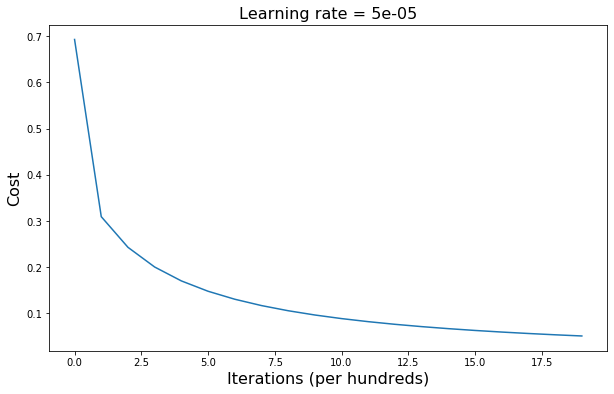

In [15]:
# Run the model
d = model(xTrainFlatten,yTrain,xTestFlatten,yTest,num_iterations=2000,learning_rate=0.00005,print_cost=False)

# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
fig,ax = plt.subplots(figsize=(10,6));
ax.plot(costs);
ax.set_ylabel('Cost',fontsize=16);
ax.set_xlabel('Iterations (per hundreds)',fontsize=16);
ax.set_title("Learning rate = " + str(d["learning_rate"]),fontsize=16);

So we can see that the model performed as expected: the cost was reduced due to gradient descent over the course of the iteration, and the cost appears to have been leveling out just below $J = 0.1$. One thing to note is that the model was giving a cost of `NaN` with a slightly larger learning rate. I would like to investigate this a bit more in the future. I think the "ideal" learning rate for a neural network is dependent on the data, so I'm not too worried about this. For now, let's test some other learning rate values around this one to see how the model performs.

Learning Rate: 0.0005
Train accuracy: 100.0 %
Test accuracy: 67.77777777777777 %

Learning Rate: 5e-05
Train accuracy: 100.0 %
Test accuracy: 65.55555555555556 %

Learning Rate: 5e-06
Train accuracy: 90.47619047619048 %
Test accuracy: 67.77777777777777 %



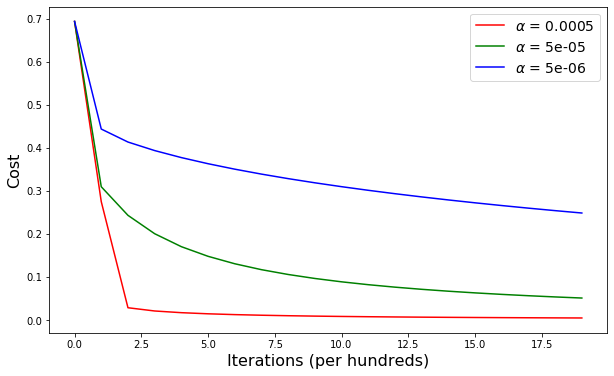

In [16]:
# Set a few learning rates and run the model
learningRateList = [0.0005,0.00005,0.000005]
d = []
for learningRate in learningRateList:
    print("Learning Rate: "+str(learningRate))
    d.append(model(xTrainFlatten,yTrain,xTestFlatten,yTest,num_iterations=2000,learning_rate=learningRate,print_cost=False))
    print("")
    
# Plot learning curve (with costs)
costs1 = np.squeeze(d[0]['costs'])
costs2 = np.squeeze(d[1]['costs'])
costs3 = np.squeeze(d[2]['costs'])
fig,ax = plt.subplots(figsize=(10,6));
ax.plot(costs1,'r',label="$\\alpha$ = "+str(d[0]['learning_rate']));
ax.plot(costs2,'g',label="$\\alpha$ = "+str(d[1]['learning_rate']));
ax.plot(costs3,'b',label="$\\alpha$ = "+str(d[2]['learning_rate']));
ax.legend(fontsize=14)
ax.set_ylabel('Cost',fontsize=16);
ax.set_xlabel('Iterations (per hundreds)',fontsize=16);

Again, this acts like we should expect. As we decrease the learning rate $\alpha$, the model will take longer to optimize the parameters $w$ and $b$. 

So our model is performing just under 70\%. That's better than a coin flip, and certainly not bad for a very simple logistic regression model, but it's not great. There's a lot that could be improved here with this model's performance. Maybe using more training samples will improve the model performance. We could have also used a cross-validation data set to avoid overfitting to the training set. But there are better models suited for this task, so I won't spend more time trying to identify how to improve the logistic regression model.

Before we move on, let's first have a look at some examples the model got right and some that it got wrong.

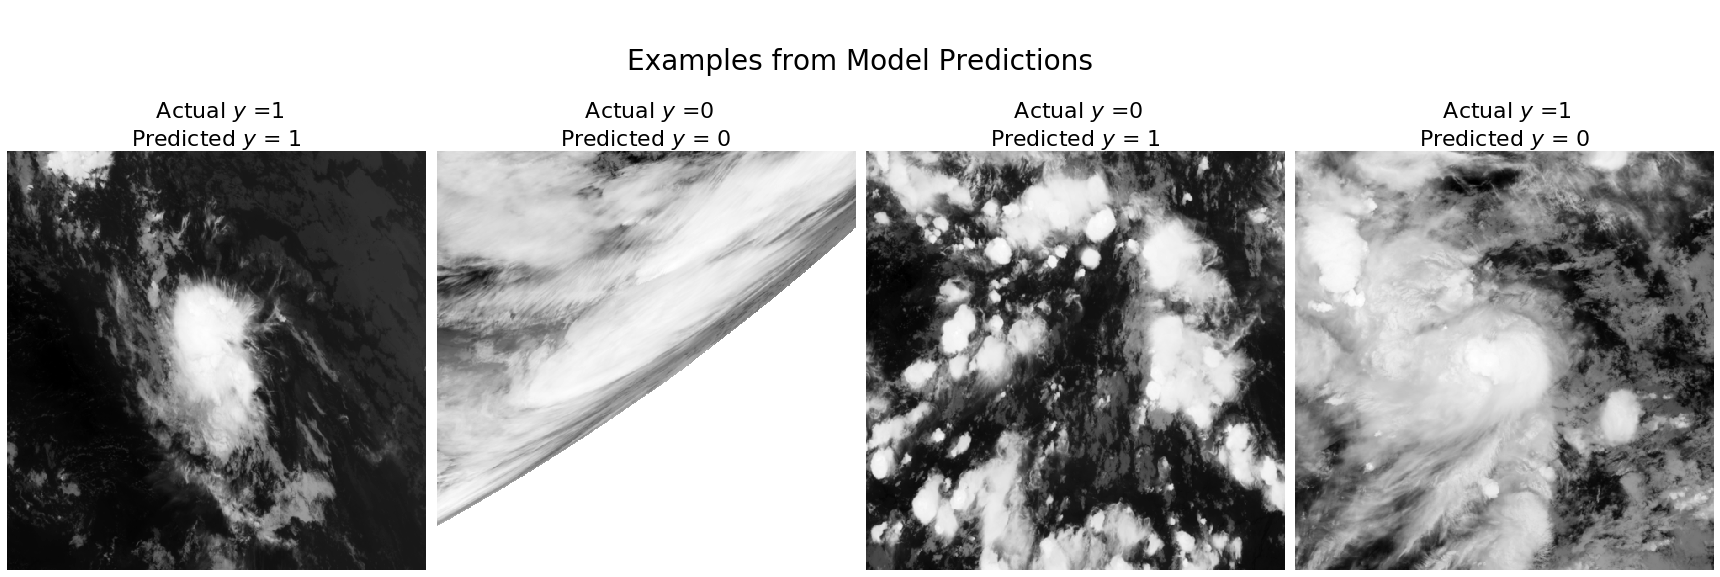

In [110]:
positivePredictionMatchInd = 0
negativePredictionMatchInd = 5
positivePredictionMismatchInd = 2
negativePredictionMismatchInd = 68

# PLot 5 examples
examples = [0,5,2,68]
fig,ax = plt.subplots(1,4,figsize=(24,8))
for i in range(4):
    ind = examples[i]
    ax[i].imshow(xTestFlatten[:,ind].reshape((498,498)),cmap='gray');
    ax[i].axis('off');
    ax[i].set_title("\n \n \n \n Actual $y$ ="+str(yTest[0,ind])+"\n"+"Predicted $y$ = "+str(int(d[1]["Y_prediction_test"][0,ind])),fontsize=22);
plt.tight_layout()
fig.suptitle("Examples from Model Predictions",fontsize=28);